In [2]:
import pandas as pd
import spacy
from spacy.lang.en import English
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import ngrams
import re
import gensim
from gensim import corpora
import pyLDAvis.gensim
from gensim.models import CoherenceModel
from gensim.models.wrappers import LdaMallet
from gensim.models import Phrases
from gensim.models.phrases import Phraser 
import pickle
from collections import OrderedDict
import matplotlib.pyplot as plt
import os
import datetime as dt
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
import seaborn as sns; sns.set_style("whitegrid"); sns.set_palette("Set2")
import matplotlib.pyplot as plt 
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [81]:
## Load mallet package
os.environ['MALLET_HOME'] = 'C:/Users/josh.a.peters/Desktop/mallet-2.0.8/mallet-2.0.8' # update this path
mallet_path = 'C:/Users/josh.a.peters/Desktop/mallet-2.0.8/mallet-2.0.8/bin/mallet' # update this path

In [11]:
import ast

In [12]:
reddit_df = pd.read_csv('C:/Users/josh.a.peters/Desktop/reddit_df.csv')
reddit_df['tokenized_list'] = reddit_df['tokenized_list'].apply(lambda x: ast.literal_eval(x))

In [13]:
text_data = reddit_df['tokenized_list'].tolist()

In [3]:
test = gensim.models.ldamodel.LdaModel.load('..\Models\model6.gensim')


<>:1: DeprecationWarning: invalid escape sequence \M
<>:1: DeprecationWarning: invalid escape sequence \M
<>:1: DeprecationWarning: invalid escape sequence \M
<ipython-input-3-22f026b1ff07>:1: DeprecationWarning: invalid escape sequence \M
  test = gensim.models.ldamodel.LdaModel.load('..\Models\model6.gensim')


In [15]:
#ldamodel = gensim.models.ldamodel.LdaModel.load('..\Models\model5.gensim')

lda_display = pyLDAvis.gensim.prepare(test, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)
pyLDAvis.save_html(lda_display, r'../Visualisations/visualisation_v6.html')


C:\Users\josh.a.peters\AppData\Local\Continuum\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


# Vader

In [210]:
from nltk import sent_tokenize

In [208]:
def calculate_sent_score_sent(df, column):
    """
    (DataFrame, string -->list)

    For a given column containing text, calculate the sentiment score for each sentence, and take the average of the whole string
    """
    #initialize vader
    sia = SIA()
    #empty lists to store results
    results = []
    results_score = []
    results_sent = []
    #go through each text value and each sentence, and apply vader
    for value in df[column].astype(str):
        if value!= 'nan':
            sent_list = sent_tokenize(value)
            sent_results = []
            score = []
            for i in range(len(sent_list)):
                pol_score = sia.polarity_scores(sent_list[i])
                pol_score['text'] = sent_list[i]
                sent_results.append(pol_score)
                score.append(sent_results[i]['compound'])
            if len(sent_list) >0:
                full_score = (sum(score))/(len(score))
            else:
                full_score = sum(score)
            results.append(full_score)
            results_score.append(score)
            results_sent.append(sent_list)

        else:
            results.append(None)
            results_score.append(None)
            results_sent.append(None)
    #add to df
    df['full_post_score'] = results
    df['full_post_all_scores'] = results_score
    df['full_post_all_sentences'] = results_sent


    return df

In [211]:
df_vader = calculate_sent_score_sent(reddit_df, 'body')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000023BDAF68828>]],
      dtype=object)

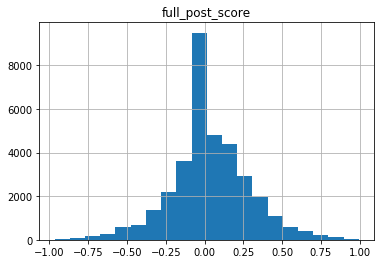

In [221]:
df_vader.hist('full_post_score', bins= 20 )

In [229]:
df_vader['clean_date_sub'] = df_vader['created'].apply(lambda x: dt.datetime.utcfromtimestamp(x)).apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S'))


In [233]:
df_vader['year_sub'] = df_vader['clean_date_sub'].str.split("-", expand = True)[0]
df_vader['month_sub'] = df_vader['clean_date_sub'].str.split("-", expand = True)[1]
df_vader['day_sub'] = df_vader['clean_date_sub'].str.split("-", expand = True)[2].str[:2]

In [237]:
#combine year and month
df_vader['yearmonth_sub'] = df_vader['year_sub'] + df_vader['month_sub']
#combine year month and day
df_vader['yearmonthday_sub'] = df_vader['year_sub'] + df_vader['month_sub'] + df_vader['day_sub']


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <a list of 13 Text xticklabel objects>)

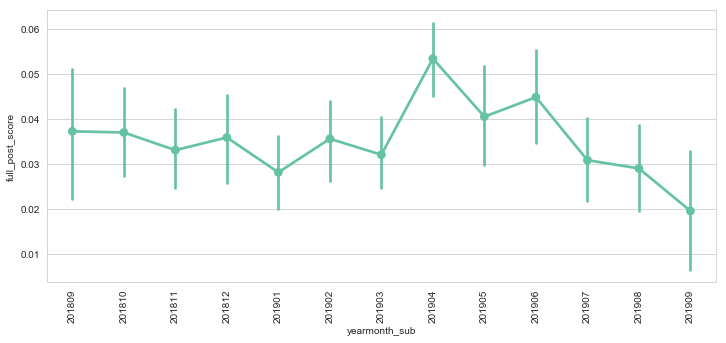

In [245]:
fig, (ax1) = plt.subplots()
fig.set_size_inches(12,5)
plot = sns.pointplot(x= 'yearmonth_sub', y="full_post_score", data= df_vader)
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
 <a list of 31 Text xticklabel objects>)

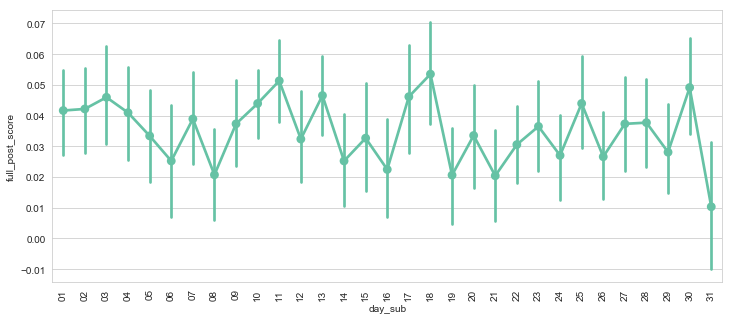

In [246]:
fig, (ax1) = plt.subplots()
fig.set_size_inches(12,5)
plot = sns.pointplot(x= 'day_sub', y="full_post_score", data= df_vader)
plt.xticks(rotation=90)

In [256]:
df_vader['sent_flag'] = df_vader['full_post_score'].apply(lambda x : 'pos' if x > 0.5 else ('neg' if x < -0.5 else 'neu'))

In [261]:
def prop(df, col1, col2, join):
    """
    (DataFrame, string, string, string --> DataFrame)
    Takes original dataframe, two columns and returns a dataframe with a column showing the proportion of the first variable in
    the second variable. For example, if the second variable is month, and first is gender, it would show the proportion of males
    and females specific to that month
    
    """
    prop_group = pd.DataFrame(df.groupby([col1, col2]).count()[join].reset_index())
    col2_totals = pd.DataFrame(df.groupby(col2).count()[join]).reset_index()
    merge = pd.merge(prop_group, col2_totals, 'outer',col2)
    merge['prop']= merge[join +'_x']/ merge[join +'_y']
    
    return merge

In [268]:
prop_sent = prop(df_vader, 'sent_flag', 'yearmonth_sub', 'Unnamed: 0')

In [272]:
prop_sent.head()

,sent_flag,yearmonth_sub,Unnamed: 0_x,Unnamed: 0_y,prop
0,neg,201809,28,1182,0.023689
1,neu,201809,1112,1182,0.940778
2,pos,201809,42,1182,0.035533
3,neg,201810,81,2805,0.028877
4,neu,201810,2601,2805,0.927273


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <a list of 13 Text xticklabel objects>)

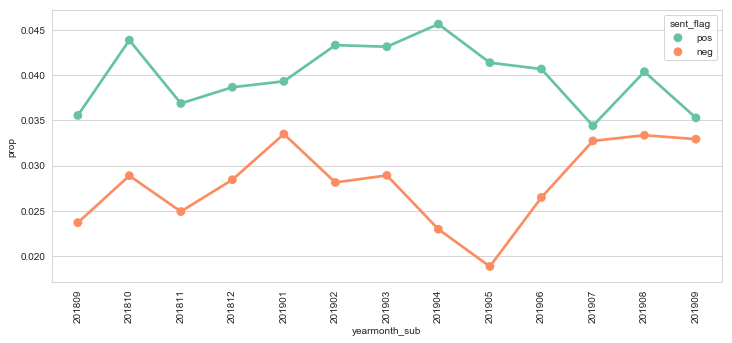

In [276]:
fig, (ax1) = plt.subplots()
fig.set_size_inches(12,5)
plot = sns.pointplot(x= 'yearmonth_sub', y="prop", data= prop_sent[prop_sent['sent_flag'] != 'neu'], hue = 'sent_flag', hue_order=['pos', 'neg'])
plt.xticks(rotation=90)

In [277]:
def tfidfVectorize(df, col, ngram1, ngram2):
    for_vector = []
    for value in df[col].astype(str):
        if value != 'nan':
            for_vector.append(value)
    # settings that you use for count vectorizer will go here
    tfidf_vectorizer=TfidfVectorizer(use_idf=True, norm=None, ngram_range=(ngram1,ngram2))
    
    # just send in all your docs here
    tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(for_vector)
    
    for i in range(len(for_vector)):
        if i == 0:
            sum_vector = tfidf_vectorizer_vectors[0].T.todense()
        else:
            i_vector = tfidf_vectorizer_vectors[i].T.todense()
            sum_vector += i_vector 
            
    avg_vector = sum_vector/len(for_vector)
    df_tfidf = pd.DataFrame(avg_vector, index=tfidf_vectorizer.get_feature_names(), columns=["tfidf"])
    df_tfidf = df_tfidf.sort_values(by=["tfidf"],ascending=False)
    
    return df_tfidf

In [287]:
tfidfVectorize(df_vader[df_vader['sent_flag'] == 'neg'], 'body', 3, 3)[:25]

,tfidf
on the ttc,0.121203
the ttc is,0.112824
on the subway,0.106242
one of the,0.094549
car crashes into,0.086812
www cbc ca,0.075783
toronto citynews ca,0.072343
https toronto citynews,0.072343
cbc ca news,0.071930
https www cbc,0.071930


In [288]:
tfidfVectorize(df_vader[df_vader['sent_flag'] == 'pos'], 'body', 3, 3)[:25]

,tfidf
power station china,0.618822
on the ttc,0.102747
the ttc is,0.097260
horse racing industry,0.080020
in the city,0.076516
on the subway,0.076516
if you re,0.074217
one of the,0.071193
out of the,0.067446
30 pm free,0.065639


In [300]:
import numpy as np

In [306]:
getTFIDFandCount(df_vader[df_vader['sent_flag'] == 'neg']['body'],(3,3))

,term,tfidf,counts
0,on the ttc,0.024270,26
1,the ttc is,0.022768,24
2,on the subway,0.020179,22
3,one of the,0.016675,19
4,if you re,0.011250,12
5,on public transit,0.009767,10
6,to pay for,0.009552,10
7,it would be,0.008752,11
8,the ttc has,0.008200,11
9,www cbc ca,0.002099,12


In [305]:
def getTFIDFandCount(df_col, ngramrange):
    """(DataFrame, tuple --> DataFrame)
    Takes a column of a dataframe and the range for n-gram analysis to find the TF-IDF for each
    n-gram in the column.

    Returns a DataFrame of the top 10 n-grams, TF-IDF score, and actual count of n-gram appearance.
    """
    cv=CountVectorizer(ngram_range=ngramrange, max_features=15)
    word_count_vector=cv.fit_transform(df_col.unique())
    feature_names = cv.get_feature_names()

    # Transforming top 400 most common words to produce TF-IDF score
    tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
    tfidf_transformer.fit(word_count_vector)
    tfidf_vector=tfidf_transformer.transform(word_count_vector)

    # Combining TF-IDF score with the words into a dictionary
    weights = np.asarray(tfidf_vector.mean(axis=0)).ravel().tolist()
    df_tfidf = pd.DataFrame(weights, index=feature_names, columns=["tfidf"])
    df_tfidf = df_tfidf.sort_values(by=["tfidf"],ascending=False).reset_index()
    df_tfidf.rename(index=str, columns={"index": "term"}, inplace=True)

    # Counting the actual number of occurances and appending to dictionary of word
    # with TF-IDF value
    count_list = word_count_vector.toarray().sum(axis=0)
    actual_count_dict = {"term": feature_names, "counts": count_list}
    actual_count_df = pd.DataFrame.from_records(actual_count_dict)
    tfidf_and_count = pd.merge(df_tfidf, actual_count_df, on='term', how='left')
    return tfidf_and_count

def add_tfidf_column(full_df, month, suffix):
    """(DataFrame, string, string --> DataFrame)
    Takes the filtered dataframe to generate TFIDF scores for, as well as the month
    and suffix relating to what the dataframe has been filtered for (i.e. mental health
    or sarcastic posts).

    Returns the top 10 TFIDF for the filtered dataframe, for that month.
    """
    tfidf_df = getTFIDFandCount(full_df["Post_Clean"],(2, 4))
    tfidf_df = tfidf_df[:10]
    tfidf_df = tfidf_df.add_suffix(suffix)
    return tfidf_df

def create_monthly_tfidf(full_df):
    """(DataFrame --> DataFrame)
    Taking the Reddit dataframe and combining it with the dataframe of TF-IDF values
    so each month is matched up with the most popular TF-IDFs for that month.

    Returns a dataframe with a new column for most popular TF-IDFs of that month.
    """
    all_tfidf = pd.DataFrame()
    # Filters out empty posts as well as mental health monday posts, since they
    # skew the popular word count

    full_df = full_df[~full_df["Post_Clean"].isnull()]
    full_df = full_df[~full_df["Post_Clean"].str.contains("mental health monday")]

    # Getting the unique month and years for the reddit data and iterating through
    # each month-year combination
    all_time = full_df.yearmonth_sub.unique()
    for month in all_time:
        filtered = full_df[full_df.yearmonth_sub == month]
        # Generate top 10 monthly TF-IDF for all posts
        tfidf_df = getTFIDFandCount(filtered["Post_Clean"],(2, 4))
        tfidf_df = tfidf_df[:10]
        tfidf_df["yearmonth_sub"] = month
        # Generate top 10 monthly TF-IDF for all MH posts
        mh_filtered = filtered[filtered.mh_combined_updated > 0.7]
        if len(mh_filtered) > 1:
            mh_tfidf_df = add_tfidf_column(mh_filtered, month, '_mh')
            tfidf_df = pd.concat([tfidf_df, mh_tfidf_df], axis=1, sort=True)
        # Generate top 10 monthly TF-IDF for all sarcastic posts
        sarc_filtered = filtered[filtered.prob_sarc > 0.8]
        if len(sarc_filtered) > 1:
            sarc_tfidf_df = add_tfidf_column(sarc_filtered, month, '_sarc')
            tfidf_df = pd.concat([tfidf_df, sarc_tfidf_df], axis=1, sort=True)
        # Adding filtered TFIDF columns to master TFIDF dataframe with the top
        # terms for all posts
        all_tfidf = all_tfidf.append(tfidf_df, ignore_index=True, sort=True)
        
    return all_tfidf
